cblogo.svg

<h1><center><b>CAPITAL BIKESHARE (June 2022-May 2023)</b></h1></center>


<center><b>Descriptive and Predictive Analysis</b>


by Regina Bauernschmidt

July 2023</center>



# Introduction

[Capital Bikeshare](https://capitalbikeshare.com/) is metro DC's bikeshare system, with more than 5,000 bikes available at 600 stations across seven jurisdictions.

Bike rides can be taken as a "member" or as a "casual" rider, with the option of either a classic or an electric bike. Member/Casual rides and Classic/Electric bikes each have their own prospective pricing which depends on the duration (in minutes) of the ride.

Bikes can be returned to any station- not necessarily the station from which it came. One common issue for bike sharing programs is the inbalance of bikes at stations. This can be due to weather, altitude, or events, among other things. The imbalance creates scenarios where customers can't rent a bike from empty stations, or return bikes to full stations. Ultimately, this results in customer dissatisfaction, an inbalanced traffic flow, and loss of potential revenue.

Capital Bikeshare currently attempts to remedy this through its "Bike Angels" program, in which a rider can "ride bikes from crowded stations to those that are running low on bikes, making the system work better for everyone" in exchange for rewards.

On May 1, 2023, Capital Bikeshare [added 900 electric bikes](https://www.gwhatchet.com/2023/04/27/capital-bikeshare-to-add-900-e-bikes-to-district-area-bike-stations/) to its fleet. This increase in bike supply can be expected to effect the frequency of rides and the amount of revenue ultimately generated.


# Problem Statement

Given the above, this study will explore:

- Current behavior of members vs. casual riders (i.e. the duration/frequency of their rides with respect to type of bike taken) from June 2022-May 2023

- Revenue estimate for June 2022 - May 2023

- Popular stations and routes of members vs. casual riders

- Stations and areas that are gaining/losing bikes at an unequal rate, using Tableau for map functionality

- Prediction of ride frequency and revenue from June 2023-May 2024 using Facebook's Prophet forecasting model

# 2. Data Source


This data was
sourced directly from [Capital Bikeshare](https://s3.amazonaws.com/capitalbikeshare-data/index.html), merging the last 12 months of data (3,838,644 instances) from June 2022 - May 2023.

Duplicates rows and rows with NaN values were removed. "Docked bikes" was also dropped as it is outside the scope of this project.

In [ ]:
#data analysis and wrangling

import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#forecasting
from prophet import Prophet



In [ ]:
# read original dataset
df = pd.read_csv("/content/drive/MyDrive/combinedbikes.csv")

# shape of original dataset
df.shape

<ipython-input-2-45d896c3ce0d>:3: DtypeWarning: Columns (5,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/combinedbikes.csv")


(3838644, 13)

In [ ]:
# drop duplicates
df = df.drop_duplicates()
df.drop(index=df.index[389656], inplace=True)
df.dropna(inplace=True)

In [ ]:
# drop docked bikes
df.drop(df[df['rideable_type'] == "docked_bike"].index, inplace = True)

# Descriptive Statistics


**ORIGINAL DATSET FEATURES:**
*   Start Date – Includes start date and time
*   End Date – Includes end date and time
*  Start Station – Includes starting station name, number, and location
*  End Station – Includes ending station name and number, and location
* Rideable Type - Includes type of bike (classic or electric)
*  Member Type – Indicates whether user was a "registered" member (Annual Member or 30-Day Member) or a "casual" rider (Single Trip or  24-Hour Pass)

(https://capitalbikeshare.com/system-data)

In [ ]:
print(df.columns.values)

['ride_id' 'rideable_type' 'started_at' 'ended_at' 'start_station_name'
 'start_station_id' 'end_station_name' 'end_station_id' 'start_lat'
 'start_lng' 'end_lat' 'end_lng' 'member_casual']


In [ ]:
#@title
#preview dataset
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,7E4A3A88DA791628,classic_bike,2022-06-21 07:12:11,2022-06-21 07:15:20,Long Bridge Aquatic Center,31950.0,Long Bridge Park / Long Bridge Dr & 6th St S,31090.0,38.870561,-77.044095,38.865553,-77.05003,member
1,9D05B4C81F3686B4,classic_bike,2022-06-29 15:01:20,2022-06-29 16:07:36,8th & Eye St SE / Barracks Row,31608.0,Jefferson Dr & 14th St SW,31247.0,38.8792,-76.9953,38.888553,-77.032427,member
4,BFEF6DFC09107A32,classic_bike,2022-06-02 13:01:02,2022-06-02 14:05:56,8th & Eye St SE / Barracks Row,31608.0,Good Hope Rd & MLK Ave SE,31802.0,38.8792,-76.9953,38.867373,-76.988039,casual
5,858C2A5FF669F101,classic_bike,2022-06-19 11:40:07,2022-06-19 11:57:15,Corporate Blvd & Omega Dr,32071.0,Shady Grove Metro West,32045.0,39.106971,-77.192645,39.119765,-77.166093,casual
6,84FE382844FC5D3D,classic_bike,2022-06-08 17:53:12,2022-06-08 17:59:41,Market Square / King St & Royal St,31042.0,Saint Asaph St & Madison St,31097.0,38.804718,-77.043363,38.812718,-77.044097,member


## **Ride Duration**

In [ ]:
# new feature calculating ride duration
df['starttime']= pd.to_datetime(df['started_at'], errors='coerce')
df['endtime']= pd.to_datetime(df['ended_at'], errors='coerce')
df['elapsed_time'] = df["endtime"] - df["starttime"]

In [ ]:
# convert ride duration to minutes
from datetime import timedelta

duration = timedelta(minutes=1)
df["elapsed_time_min"] = df['elapsed_time'] / duration

In [ ]:
# distribution of ride duration

pd.options.display.float_format = '{:.2f}'.format
df.elapsed_time_min.describe()

count   3350588.00
mean         17.72
std          38.57
min         -56.27
25%           6.52
50%          11.07
75%          18.87
max        1499.68
Name: elapsed_time_min, dtype: float64

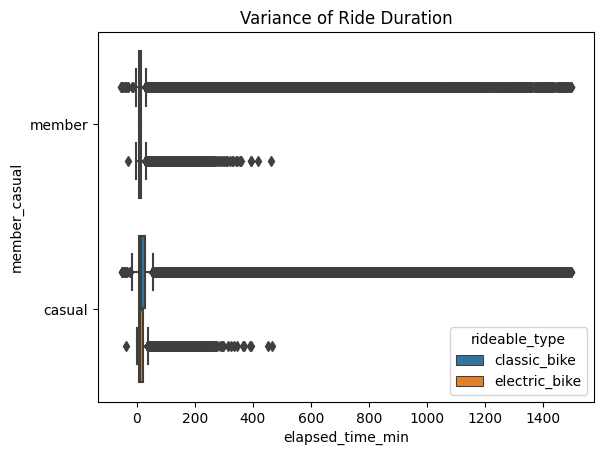

In [ ]:
#@title
# boxplot of ride duration with outliers
fig, ax = plt.subplots()
sns.boxplot(data=df, y="member_casual", x="elapsed_time_min", hue="rideable_type")
plt.title("Variance of Ride Duration")
plt.show()

*INSIGHTS:*
*   Rides with negative duration are erroneous. These (59) instances should be investigated, and will henceforth be removed from the dataset.
*  The longest ride duration is almost 25 hours.
*   Classic bikes have a higher number and range of outliers. Longer rides are more likely in classic bikes because they are both cheaper and easier to transport.
* Outliers will remain in the analysis but removed from the box plot for clarity.

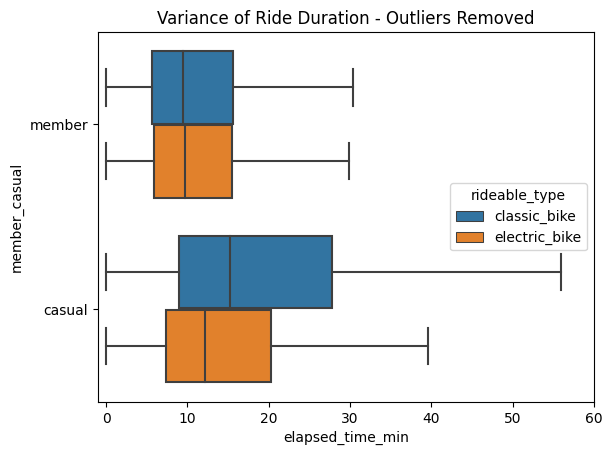

In [ ]:
# drop rides with a negative duration
df = df[df.elapsed_time_min >= 0]


# boxplot of ride duration without outliers
fig, ax = plt.subplots()
sns.boxplot(data=df, y="member_casual", x="elapsed_time_min", hue="rideable_type", fliersize="0")
ax.set_xlim(-1, 60)
plt.title("Variance of Ride Duration - Outliers Removed")
plt.show()

*INSIGHTS:*


* Casual riders take longer rides than members, especially on classic bikes.
* With members, ride duration is distributed similarly in both types of bikes.

## **Ride Frequency**

In [ ]:
# describe final version of dataset
df.describe(include=['O'])

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
count,3350529,3350529,3350529,3350529,3350529,3350529.00,3350529,3350529.00,3350529.00,3350529.00,3350529.00,3350529.00,3350529
unique,3350529,2,3053347,3048427,773,1462.00,776,1463.00,273066.00,282209.00,1599.00,1600.00,2
top,7E4A3A88DA791628,classic_bike,2023-04-18 18:07:08,2023-04-05 09:21:17,Columbus Circle / Union Station,31229.00,Columbus Circle / Union Station,31229.00,38.92,-77.04,38.92,-77.04,member
freq,1,2962925,6,33,38851,32047.00,39088,31105.00,29383.00,29386.00,31105.00,31105.00,2130363


In [ ]:
# proportion of classic/electric bike taken by member type
df.groupby('member_casual')['rideable_type'].value_counts(normalize=True)

member_casual  rideable_type
casual         classic_bike    0.87
               electric_bike   0.13
member         classic_bike    0.89
               electric_bike   0.11
Name: rideable_type, dtype: float64

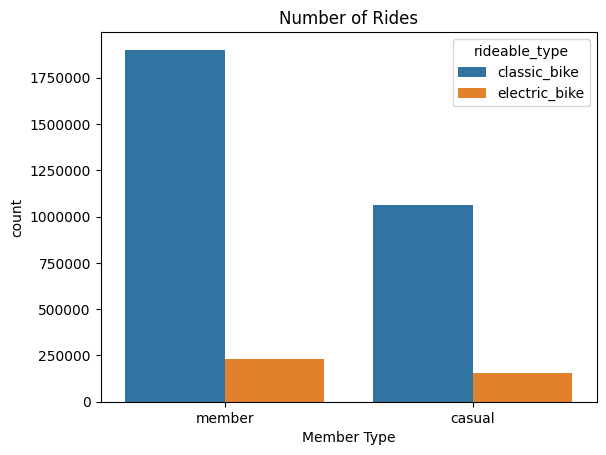

In [ ]:
# barchart of ride frequency
sns.countplot(x="member_casual",
            hue="rideable_type",
            data=df)
plt.title("Number of Rides")
plt.xlabel("Member Type")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

*INSIGHTS:*
* There were a total of 3,350,529 rides taken from June 2022-May 2023- approximately 9,180 rides per day.
* Classic bikes were taken most frequently, ~88.4% of the time.
* Most rides are taken by members (~63.5%).

## **Frequent Stations and Routes**

In [ ]:
# new feature counts number of times a bike started and/or ended at a station
totalcounts = df.start_station_name.value_counts()+df.end_station_name.value_counts()

In [ ]:
# most popular stations overall
totalcounts.nlargest(10)

Columbus Circle / Union Station                       77939.00
New Hampshire Ave & T St NW                           74712.00
15th & P St NW                                        70111.00
1st & M St NE                                         59842.00
5th & K St NW                                         59761.00
14th & V St NW                                        55506.00
Eastern Market Metro / Pennsylvania Ave & 8th St SE   54615.00
Massachusetts Ave & Dupont Circle NW                  54259.00
14th & R St NW                                        50456.00
Lincoln Memorial                                      50258.00
dtype: float64

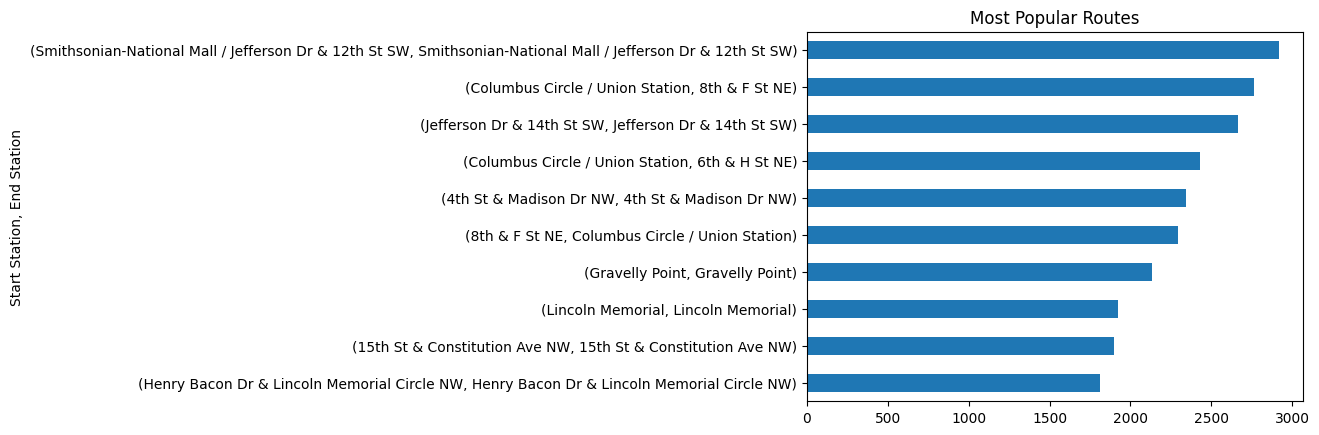

In [ ]:
# most popular routes
df.groupby(['start_station_name', 'end_station_name'])['ride_id'].count().nlargest(10).iloc[::-1].plot(kind='barh')
plt.title("Most Popular Routes")
plt.ylabel("Start Station, End Station")
plt.show()

*INSIGHTS:*
* Columbus Circle/Union Station is the most frequented station overall.
* Smithsonian National-Mall to Jefferson Dr & 12th St SW is the most popular route overall.
* Rides are often not returned to the same station they began which can lead to an inbalance in bikes at each station.


In [ ]:
# frequent routes by members and casual riders
df_member_stations = df[['member_casual', 'start_station_name', 'end_station_name']].groupby('member_casual')
df_mem = df_member_stations.start_station_name.value_counts()+df_member_stations.end_station_name.value_counts()

# most popular routes for members
df_mem['member'].nlargest(5)

start_station_name               end_station_name               
New Hampshire Ave & T St NW      New Hampshire Ave & T St NW        55994
Columbus Circle / Union Station  New Hampshire Ave & T St NW        55242
New Hampshire Ave & T St NW      Columbus Circle / Union Station    54411
15th & P St NW                   New Hampshire Ave & T St NW        54293
Columbus Circle / Union Station  Columbus Circle / Union Station    53659
dtype: int64

In [ ]:
# most popular routes for casual riders
df_mem['casual'].nlargest(5)

start_station_name                           end_station_name         
Lincoln Memorial                             Lincoln Memorial             38431
                                             Jefferson Dr & 14th St SW    37167
4th St & Madison Dr NW                       Lincoln Memorial             36543
Jefferson Dr & 14th St SW                    Lincoln Memorial             36478
Henry Bacon Dr & Lincoln Memorial Circle NW  Lincoln Memorial             35398
dtype: int64

*INSIGHTS:*

*   Members most often go to/from stations: Columbus Circle/Union Station and New Hampshire Ave & T St NW.
*   Casual riders most often go to/from stations: Lincoln Memorial and Jefferson Dr & 14th St SW.
*   Members are most likely taking the train to work while casual riders are likely tourists.

## **Bike Imbalance**

In [ ]:
# new feature to determine total gain/loss of bikes per station
delta_bikes_vals = df.end_station_name.value_counts()-df.start_station_name.value_counts()

In [ ]:
#describe distribution of stations bike gain/loss
delta_bikes_vals.describe()

count     773.00
mean       -0.00
std       776.67
min     -6689.00
25%       -79.00
50%         2.00
75%        70.00
max      3717.00
dtype: float64

In [ ]:
# most bikes gained
delta_bikes_vals.sort_values(ascending=False).nlargest(5)

Thomas Jefferson St NW & Water/K St NW   3717.00
C & O Canal & Wisconsin Ave NW           3674.00
Metro Center / 12th & G St NW            3146.00
Georgetown Harbor / 30th St NW           3096.00
10th & G St NW                           2860.00
dtype: float64

In [ ]:
# most bikes lost
delta_bikes_vals.sort_values(ascending=False).nsmallest(5)

11th & Kenyon St NW            -6689.00
Park Rd & Holmead Pl NW        -6661.00
Columbia & Ontario Rd NW       -4145.00
Columbia Rd & Georgia Ave NW   -4113.00
14th & Otis Pl NW              -3731.00
dtype: float64

In [ ]:
# new dataframe made to be exported and used with Tableau's map functionality
delta_bikes = df.end_station_name.value_counts()-df.start_station_name.value_counts()
delta_bikes = delta_bikes.to_frame()
delta_bikes.reset_index(inplace=True)
delta_bikes = delta_bikes.rename(columns = {'index':"start_station_name"})
delta_bikes = delta_bikes.rename(columns = {0:'bike_change'})

In [ ]:
# dataframe with station name and location
station_loc = df[["start_station_name", "start_lat", "start_lng"]]

In [ ]:
# new dataframe combining bikes gained/lost with station's location
delta_bikes_merged = pd.merge(delta_bikes, station_loc, how='inner')

In [ ]:
# reduce precision of latitude/longitude to better match with its associated bike station
delta_bikes_merged["start_lat"] = delta_bikes_merged["start_lat"].astype(float).round(5)
delta_bikes_merged["start_lng"] = delta_bikes_merged["start_lng"].astype(float).round(5)

In [ ]:
# drop duplicates and export
delta_bikes_merged= delta_bikes_merged.drop_duplicates()
delta_bikes_merged.to_csv("delta_bikes_merge.csv")

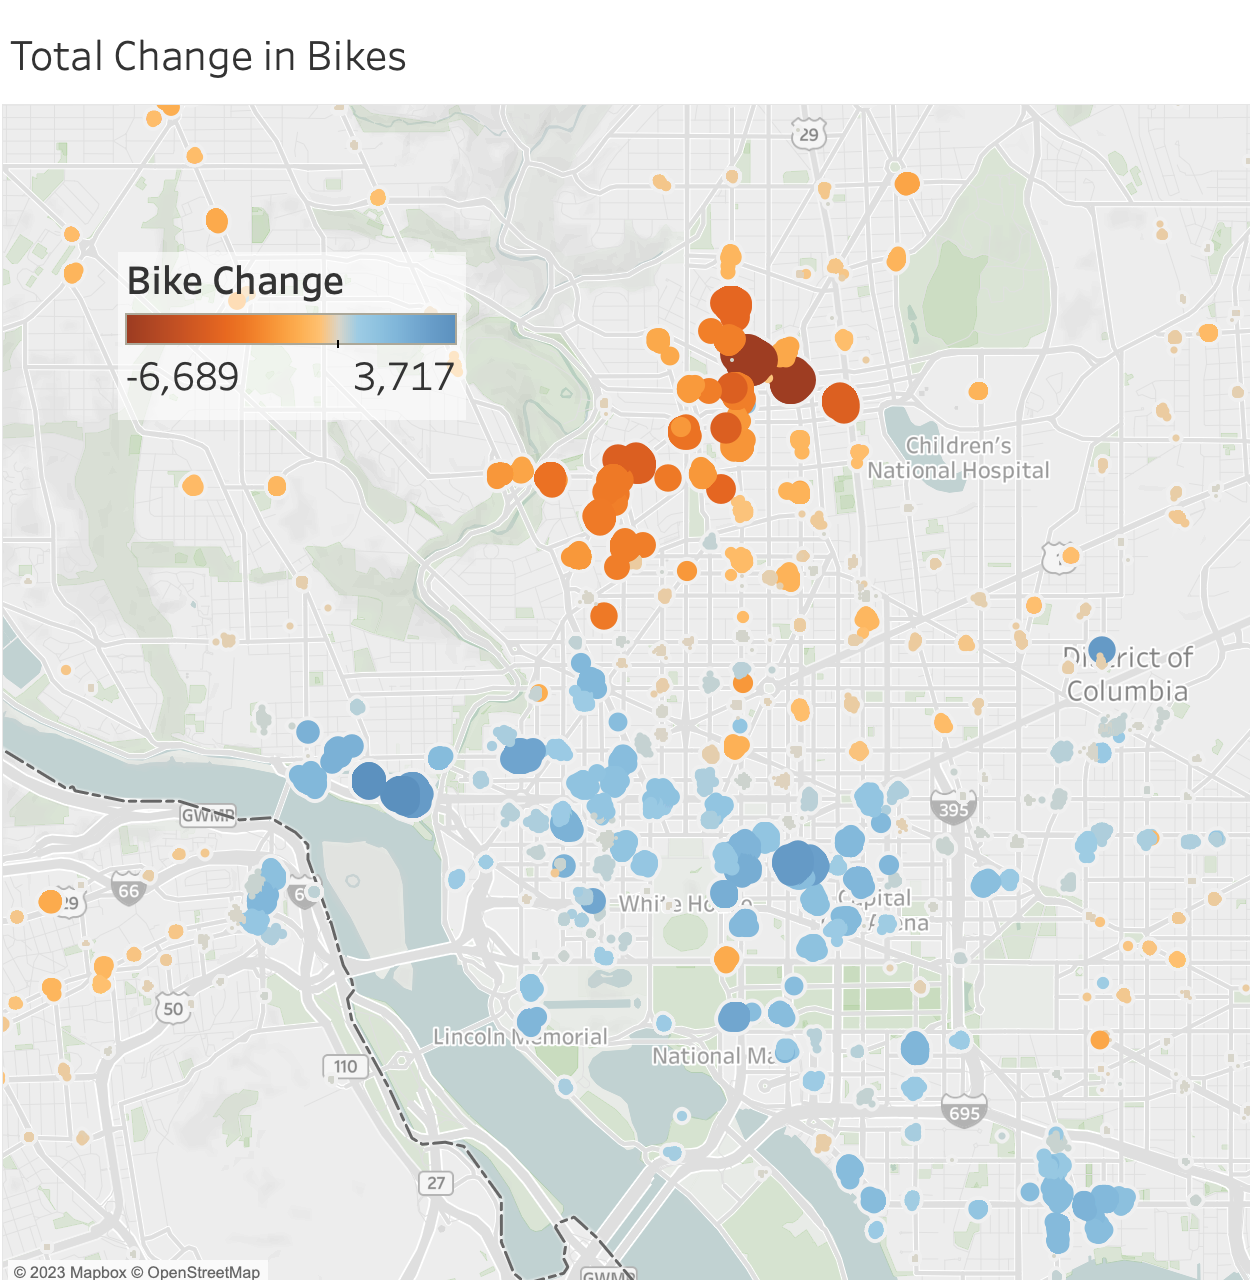

*INSIGHTS:*
*   Average bike change is 0, signifying a balance of bikes overall (i.e. all bikes are accounted for).
*   Some stations are gaining or losing thousands of bikes to other stations.
* Northern stations lose bikes towards stations near the more central area of D.C.

## **Revenue**

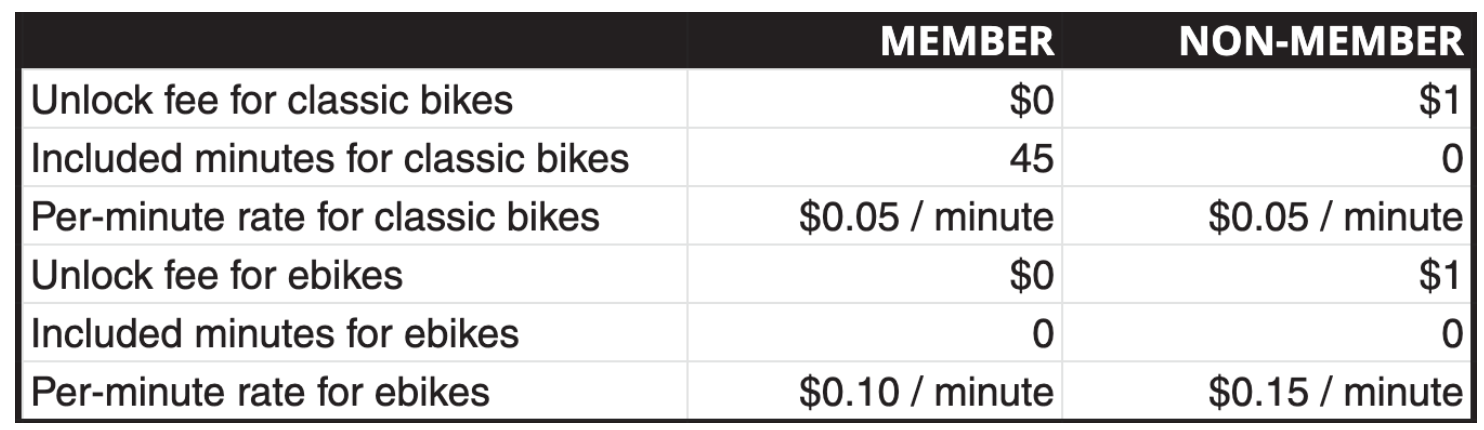

Using the given table, revenue equations were created for these 5 potential scenarios*:
* **Casual/Electric:** .15*elaped_time_min +1
* **Casual/Classic:** .05*elapsed_time_min +1
* **Member/Electric:** .1*elapsed_time_min +.198
* **Member/Classic - under 45 minutes:** .198
* **Member/Classic - over 45 minutes:** (effective_time_min-45)*.05 +.198


> **ASSUMPTIONS:*
* Casual rides were computed as single rides- not taken with a day pass.
* Members were assumed to take an average of 40 rides per month (or 2 per weekday). Since members incur a fee of \$7.92 per month, an estimated \$.198 was added to each ride.

In [ ]:
# total ride duration for each scenario
df_by_member_bikes = df[["member_casual", "rideable_type", "elapsed_time_min"]].groupby(["member_casual", "rideable_type"]).sum()
df_by_member_bikes

elapsed_time_min
member_casual rideable_type                  
casual        classic_bike        28113902.90
              electric_bike        2819660.85
member        classic_bike        25514322.73
              electric_bike        2928419.27

In [ ]:
# determine the effectively charged time in member/classic scenario
df['effective_time_min'] = np.maximum(df['elapsed_time_min']-45 * ((df["member_casual"] == "member") & (df['rideable_type'] == 'classic_bike')), 0)

In [ ]:
df_by_member_45 = df[["member_casual", "rideable_type", "effective_time_min"]].groupby(["member_casual", "rideable_type"]).sum()

In [ ]:
# calculate revenue for each potential scenario of rider and bike type
casual_electric = df_by_member_bikes.loc["casual", "electric_bike"].iloc[0]*.15+1
casual_classic = df_by_member_bikes.loc["casual", "classic_bike"].iloc[0]*.05+1
member_electric = df_by_member_bikes.loc["member", "electric_bike"].iloc[0]*.1+.198
member_classic = df_by_member_45.loc["member", 'classic_bike'].iloc[0]*.05+.198


In [ ]:
revenue = [['{0:.4f}'.format(member_classic), '{0:.4f}'.format(casual_classic)],
         ['{0:.4f}'.format(member_electric), '{0:.4f}'.format(casual_electric)]]
dfrev = pd.DataFrame(revenue, columns=['member', 'casual'])
dfrev.index=['classic', 'electric']

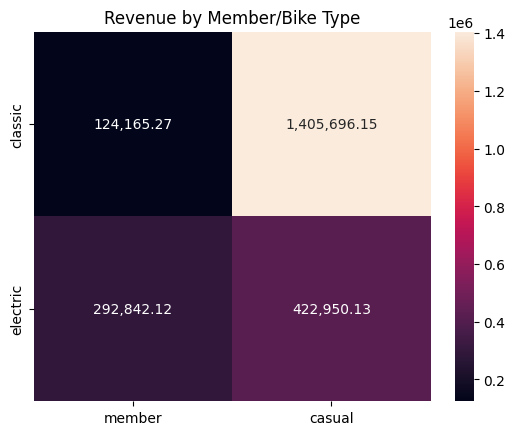

In [ ]:
#heatmap of revenue by member/bike type
dfrev = dfrev.apply(pd.to_numeric)
sns.heatmap(dfrev, annot=True, fmt=",.2f")
plt.title("Revenue by Member/Bike Type")
plt.show()

In [ ]:
# compute total revenue
total_revenue = casual_electric +  casual_classic + member_electric + member_classic
round(total_revenue,2)

2245653.67

*INSIGHTS:*
* 62.6% of revenue comes from casual riders on classic bikes.
* 81.4% of revenue comes from casual riders on either bike.
* Total revenue from these 12 months totals $2,245,653.67.


# Inferential Statistics

Inferential statistics to predict ride frequency and revenue are made using Facebook's Prophet model.

"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well." (https://facebook.github.io/prophet/docs/quick_start.html#python-api)

  ## **Ride Frequency**




In [ ]:
# calculate unique totals per diem
dfgroup = df.groupby([df['starttime'].dt.date]).nunique()

In [ ]:
dfgroup['ds']= dfgroup.index

In [ ]:
# new dataframe with data and ride frequency
df_freq = pd.DataFrame()
df_freq['ds']=dfgroup['ds']
df_freq['y']=dfgroup['ride_id']

In [ ]:
df_freq['ds']=pd.to_datetime(df_freq['ds'])

In [ ]:
# highest number of rides recorded on one day
df_freq['y'].max()

15901

In [ ]:
#fit ride frequency to model
freq_model = Prophet()
freq_model.add_seasonality(
    name='annually', period=365, fourier_order=1, prior_scale=0.1)
freq_model.fit(df_freq)

In [ ]:
# future forecast to be made for the following 365 days
future_freq = freq_model.make_future_dataframe(periods=365)

In [ ]:
freq_forecast = freq_model.predict(future_freq)

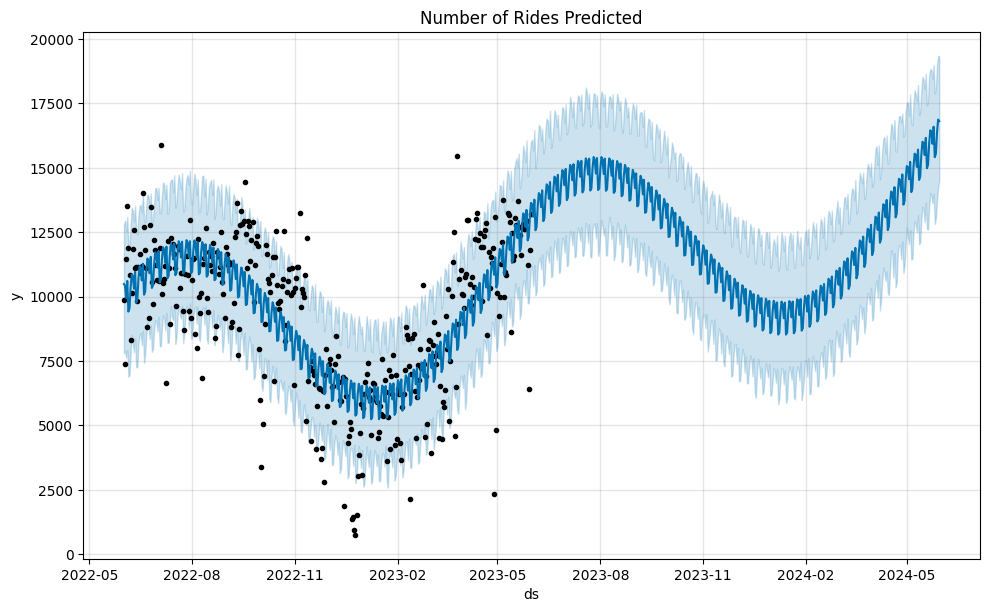

In [ ]:
# display current and predicted number of rides per day
freq_fig = freq_model.plot(freq_forecast)
plt.title("Number of Rides Predicted")
plt.show()

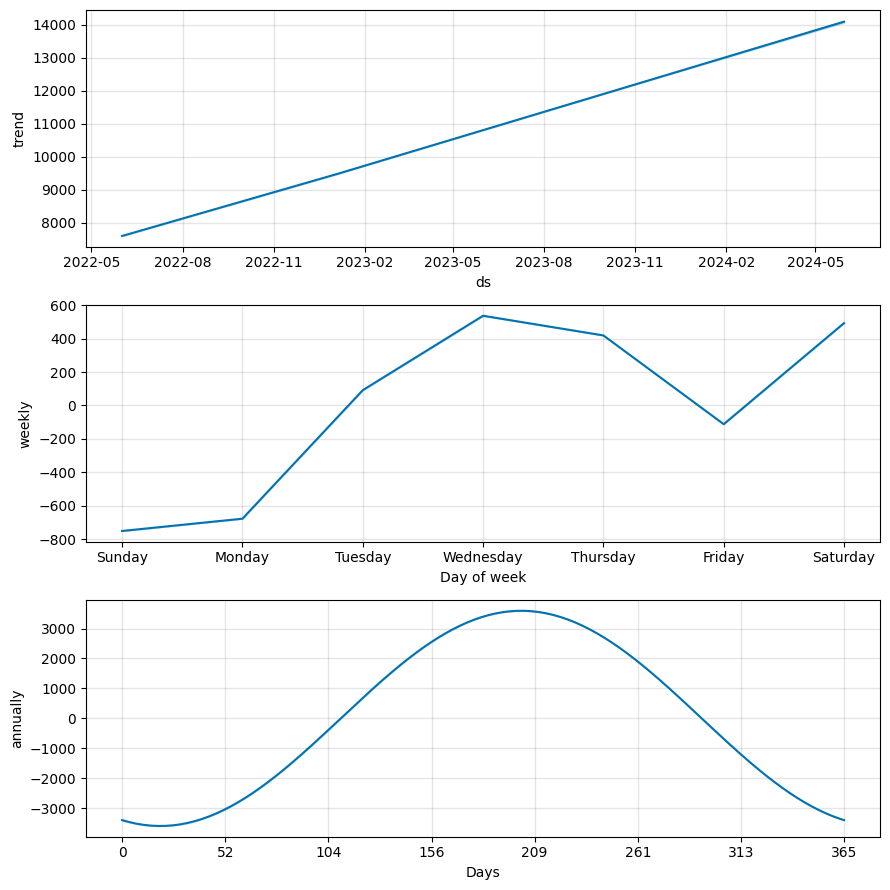

In [ ]:
# view weekly and annual trend
freq_fig2 = freq_model.plot_components(freq_forecast)

In [ ]:
# predict highest daily ride count
print(freq_forecast[freq_forecast.yhat == freq_forecast.yhat.max()])

            ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
728 2024-05-29 14078.69    14226.13    19336.61     14050.81     14106.79   

     additive_terms  additive_terms_lower  additive_terms_upper  annually  \
728         2795.24               2795.24               2795.24   2258.31   

     annually_lower  annually_upper  weekly  weekly_lower  weekly_upper  \
728         2258.31         2258.31  536.93        536.93        536.93   

     multiplicative_terms  multiplicative_terms_lower  \
728                  0.00                        0.00   

     multiplicative_terms_upper     yhat  
728                        0.00 16873.93  


In [ ]:
# predict total number of rides
next_year_freq = freq_forecast.iloc[365:729]
next_year_freq['yhat'].sum()

4526916.612624865

*INSIGHTS:*
* Wednesday and Saturday are the most popular days of the week.
* Sunday and Monday are the least popular days of the week.
* Ridership falls in winter months.
* 4,526,917 rides are predicted in the coming 12 months- an increase of 1,176,388 rides (35.1%).
* Highest number of rides recorded in one day is 15,901.
* Model predicts highest ridership levels to be reached on May 29, 2024, with around 16,874 rides that day.

## **Revenue Forecast**

In [ ]:
#determine duration in minutes for each revenue scenario
df_dates_mins=df[["member_casual", "rideable_type", "elapsed_time_min"]].groupby([df['starttime'].dt.date, "member_casual", "rideable_type"]).sum()
df_dates_mins_pivot = df_dates_mins.reset_index().pivot(values='elapsed_time_min', index='starttime', columns=['member_casual', 'rideable_type'])
df_dates_mins_pivot

member_casual       casual                     member              
rideable_type classic_bike electric_bike classic_bike electric_bike
starttime                                                          
2022-06-01        68921.25       6855.95     74558.77       8545.35
2022-06-02        47903.45       5648.47     57970.88       6306.45
2022-06-03       120187.28       9738.35     84061.23      11207.30
2022-06-04       202616.52      13287.62     97072.18       8742.80
2022-06-05       163166.90      12743.17     88199.97       8143.98
...                    ...           ...          ...           ...
2023-05-27       186904.62      33552.07     77451.60      16062.52
2023-05-28       159702.10      28187.40     56988.35      15145.03
2023-05-29        66492.55      15005.28     38033.92       8835.73
2023-05-30        74874.57      14898.38     86245.23      18782.12
2023-05-31        74170.87      17464.60     95897.63      20692.55

[365 rows x 4 columns]

In [ ]:
# revenue for casual riders on classic bikes
casual_classic_revenue = df_dates_mins_pivot['casual', 'classic_bike']*.05+1
ccr = pd.DataFrame()
ccr['y']= casual_classic_revenue.values
ccr['ds']=casual_classic_revenue.index

In [ ]:
# revenue for casual riders on electric bikes
casual_electric_revenue = df_dates_mins_pivot['casual', 'electric_bike']*.15+1
cer = pd.DataFrame()
cer['y']= casual_electric_revenue.values
cer['ds']=casual_electric_revenue.index

In [ ]:
# revenue for members on electric bikes
member_electric_revenue = df_dates_mins_pivot['member', 'electric_bike']*.05+1
mer = pd.DataFrame()
mer['y']= member_electric_revenue.values
mer['ds']=member_electric_revenue.index

In [ ]:
# effective time in minutes for member/classic bike scenario
df_dates_effective=df[["member_casual", "rideable_type", "effective_time_min"]].groupby([df['starttime'].dt.date, "member_casual", "rideable_type"]).sum()

df_dates_eff_pivot = df_dates_effective.reset_index().pivot(values='effective_time_min', index='starttime', columns=['member_casual', 'rideable_type'])

In [ ]:
# revenue for members on classic bikes
member_classic_revenue = df_dates_eff_pivot['member', 'classic_bike']*.05+.198
mcr =  pd.DataFrame()
mcr['y']= member_classic_revenue.values
mcr['ds']=member_classic_revenue.index

In [ ]:
# fit revenue model for casual riders/classic bikes
ccr_m = Prophet()
ccr_m.add_seasonality(
    name='annually', period=365, fourier_order=1, prior_scale=0.1)
ccr_m.fit(ccr)

In [ ]:
# fit revenue model for casual riders/electric bikes
cer_m = Prophet()
cer_m.add_seasonality(
    name='annually', period=365, fourier_order=1, prior_scale=0.1)
cer_m.fit(cer)

In [ ]:
# fit revenue model for members/classic bikes
mcr_m = Prophet()
mcr_m.add_seasonality(
   name='annually', period=365, fourier_order=1, prior_scale=0.1)
mcr_m.fit(mcr)

In [ ]:
# fit revenue model for members/electric bikes
mer_m = Prophet()
mer_m.add_seasonality(
    name='annually', period=365, fourier_order=1, prior_scale=0.1)
mer_m.fit(mer)

In [ ]:
# predict daily revenue for each scenario
cer_forecast = cer_m.predict(future_freq)
ccr_forecast = ccr_m.predict(future_freq)
mer_forecast = mer_m.predict(future_freq)
mcr_forecast = mcr_m.predict(future_freq)

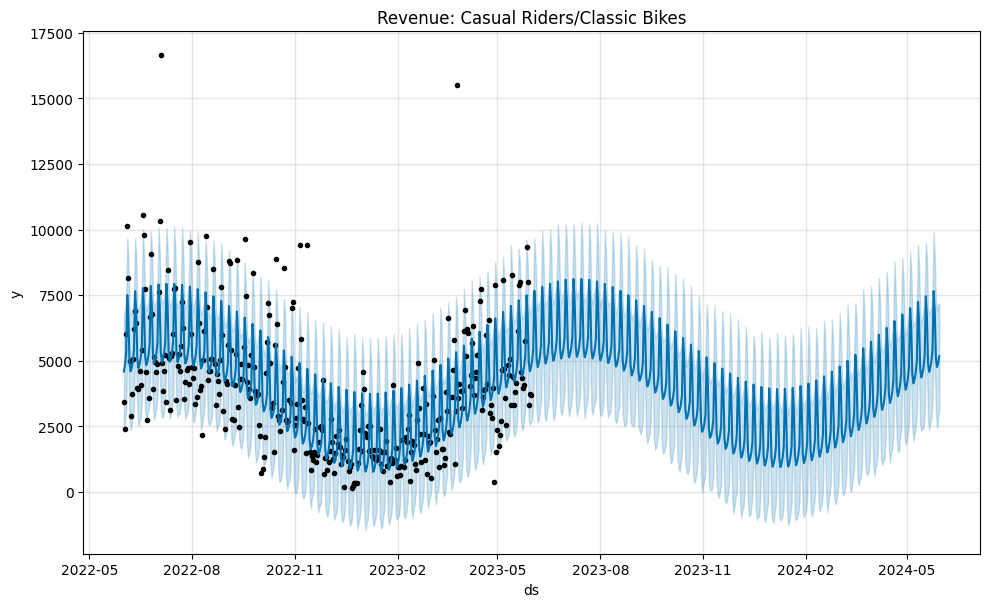

In [ ]:
ccrfig = ccr_m.plot(ccr_forecast)
plt.title("Revenue: Casual Riders/Classic Bikes")
plt.show()

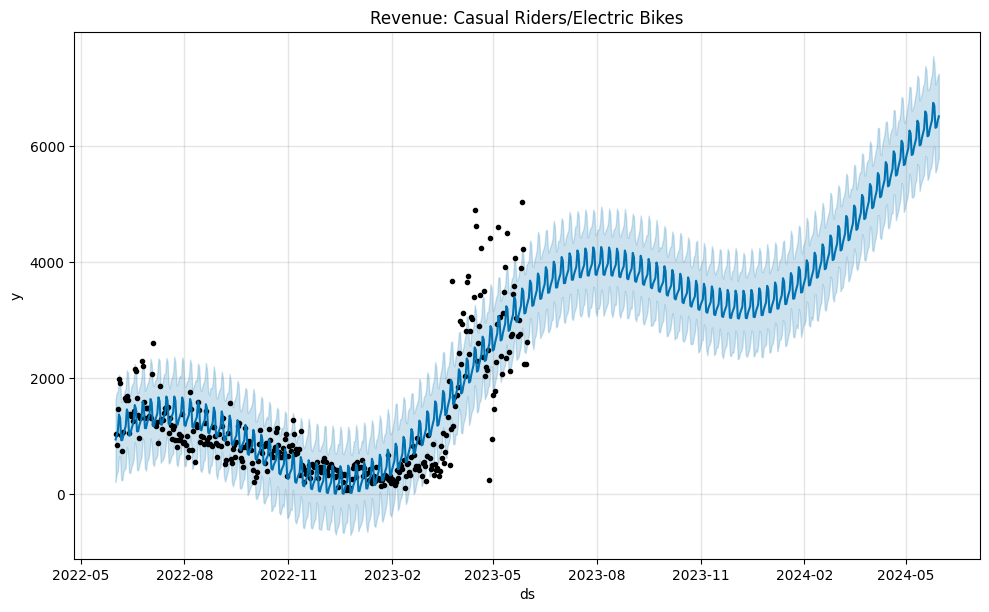

In [ ]:
cerfig = cer_m.plot(cer_forecast)
plt.title("Revenue: Casual Riders/Electric Bikes")
plt.show()

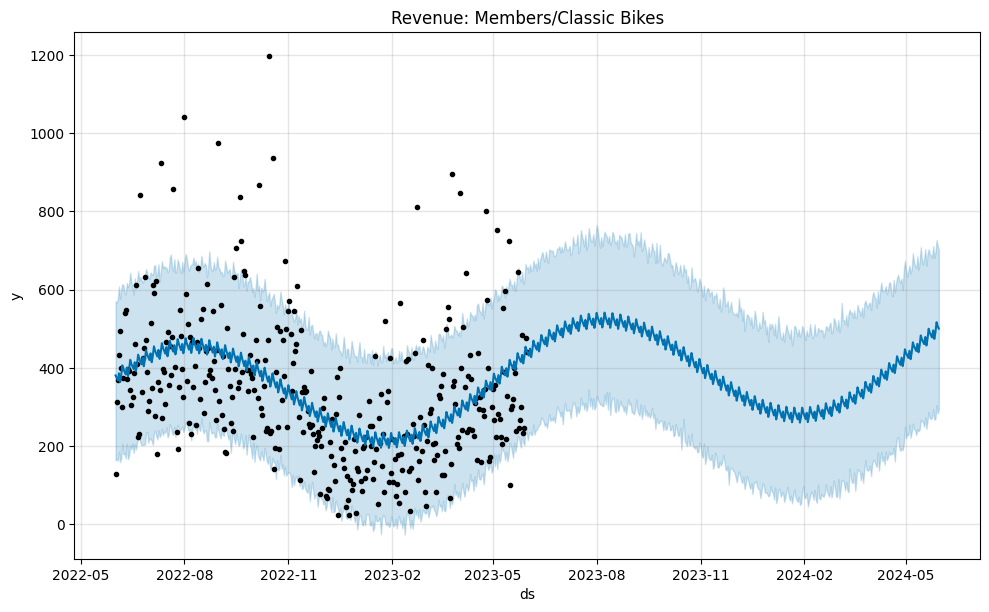

In [ ]:
mcrfig = mcr_m.plot(mcr_forecast)
plt.title("Revenue: Members/Classic Bikes")
plt.show()

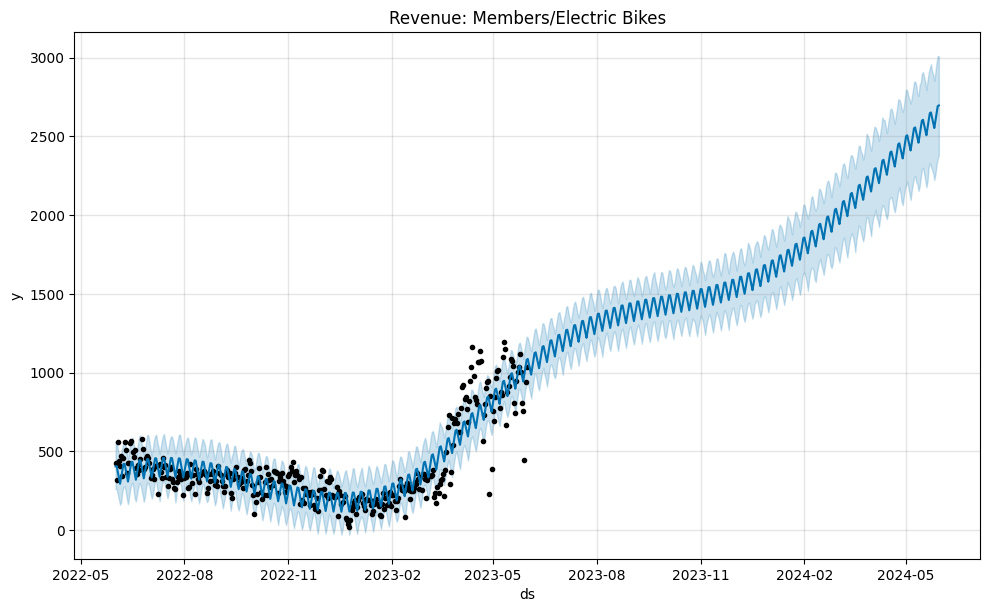

In [ ]:
merfig = mer_m.plot(mer_forecast)
plt.title("Revenue: Members/Electric Bikes")
plt.show()

*INSIGHTS:*
* While revenue from classic bikes will slightly increase in the next 12 months, revenue from electric bikes will increase dramatically.

In [ ]:
# total revenue combining revenue from each member/bike scenario
total_forecast = pd.DataFrame()
total_forecast['y'] = mcr_m.predict(future_freq)['yhat']+mer_m.predict(future_freq)['yhat']+ccr_m.predict(future_freq)['yhat']+cer_m.predict(future_freq)['yhat']
total_forecast['ds']= mer_m.predict(future_freq)['ds']

In [ ]:
# fit total revenue model
total_revenue_m = Prophet()
total_revenue_m.add_seasonality(
    name='yearly', period=365, fourier_order=1, prior_scale=0.1)
total_revenue_m.fit(total_forecast)

In [ ]:
final_forecast = total_revenue_m.predict(future_freq)

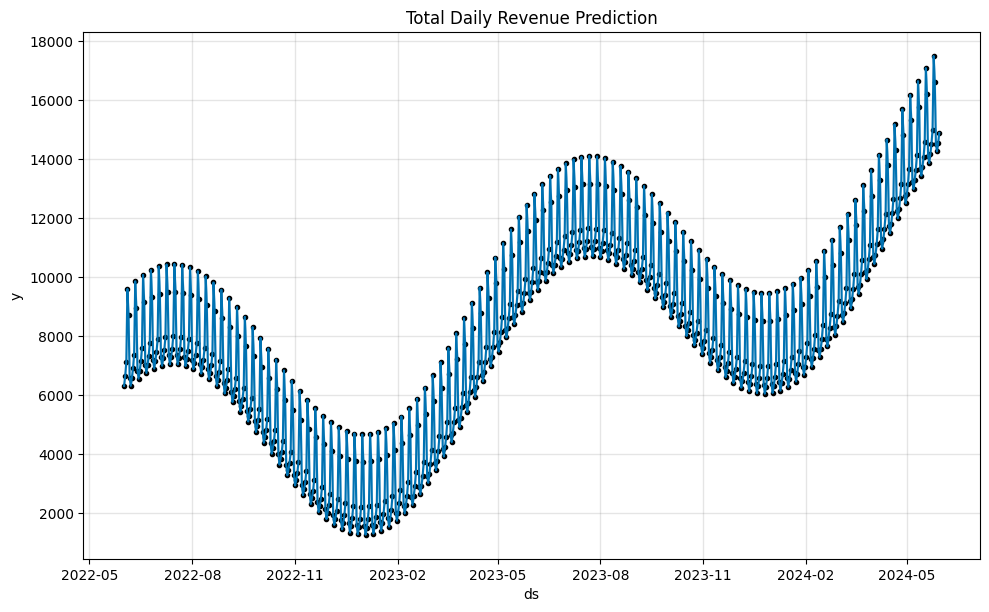

In [ ]:
totalrevfig = total_revenue_m.plot(final_forecast)
plt.title("Total Daily Revenue Prediction")
plt.show()

In [ ]:
# total revenue in next 12 months

next_year_revenue = final_forecast.iloc[365:729]
round(next_year_revenue['yhat'].sum(),2)

3717641.07

In [ ]:
#revenue for electric bikes in next 12 months

electric_car_revenue = cer_forecast.iloc[365:729]['yhat'].sum() + mer_forecast.iloc[365:729]['yhat'].sum()

round(electric_car_revenue,2)

2101174.99

*INSIGHTS:*
- Revenue is expected to increase 65.5% to \$3,717,641.07 in the next 12 month period.
- Electric bike revenue is expected to increase  to 43.48% of total revenue in the coming year.

# Conclusion

Ride Duration
- Rides are generally longer in casual members and in classic bikes.
-  Some rides glitch and log a negative duration. These, as well as rides with NaN values (potentially broken/lost/stolen bikes), should be investigated.

Ride Frequency
- Classic bikes are taken much more often, but can be expected to decrease proportionally as more electric bikes are added.

- Ride frequency follows weekly and seasonal patterns. Weekly patterns are most likely due to ridership schedules of work and play. Seasonal patterns are most likely attributed to the effects of the weather on ridership.

- About 3,350,529 rides were taken in the past 12 months, and that frequency is expected to increase 35.1% for the the following year.

Frequent Stations/Routes
- Columbus Circle/Union Station is the most popular station overall.
- Members and casual riders frequent different routes and stations, with members more focused around busy commute areras and casual riders more towards tourist destinations.

Bike Imbalance
- Bikes are "drained" from the northern districts towards the more central areas of D.C. near the White House, Lincoln Memorial, and the water.
- Some stations are gaining/losing thousands of bikes, prohibiting potential revenue.

Revenue
- Most revenue (~81.4%) currently comes from casual riders.
- Revenue is expected to increase from \$2,245,653.67 to \$3,717,641.07 in the next 12 month period - a predicted increase of 65.5%.
- This revenue is largely driven by the increase in electric bike supply and its correlated revenue from electric bike rides. While electric bike revenue made up 34% of the total in the past 12 months, that proportion should reach 43.48% from June 2023 -  May 2024.